# Projekt - KM2

Challenge 3 - blue and yellow circles

Question 1: Explain the Kandinsky Pattern in an algorithmic way, i.e. train a network which classifies Kandinsky Figures according to ground truth of challenge 3.

In [ ]:
import os
import torch
import torchvision
import random
import numpy as np
import matplotlib.pyplot as plt

if torch.cuda.is_available():  
    DEVICE = "cuda:0" 
else:  
    DEVICE = "cpu"

def masterSeed(seed):
    torch.manual_seed(seed)
    random.seed(seed)
    np.random.seed(seed)

## Pobranie danych (połączenie **false** i **counterfactual** w jedną klasę)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
! cp /content/drive/MyDrive/projekt-WB/explain.py ./explain.py
! cp /content/drive/MyDrive/projekt-WB/resnet18.py ./resnet18.py
! cp /content/drive/MyDrive/projekt-WB/train_function.py ./train_function.py
! git clone https://github.com/human-centered-ai-lab/dat-kandinsky-patterns
! mv ./dat-kandinsky-patterns/challenge-nr-3/ ./dataset

folder = './dataset/counterfactual/'
for count, filename in enumerate(os.listdir(folder)):
    dst = filename + "_counterfactual.png"
    src =f"{folder}/{filename}"
    dst =f"{folder}/{dst}"
    os.rename(src, dst)

! cp -r ./dataset/counterfactual/. ./dataset/false/
! rm -R ./dat-kandinsky-patterns
! rm -R ./dataset/counterfactual/

Cloning into 'dat-kandinsky-patterns'...
remote: Enumerating objects: 22535, done.
remote: Total 22535 (delta 0), reused 0 (delta 0), pack-reused 22535
Receiving objects: 100% (22535/22535), 396.91 MiB | 25.10 MiB/s, done.
Resolving deltas: 100% (357/357), done.
Checking out files: 100% (11253/11253), done.


## Tworzenie datasetu

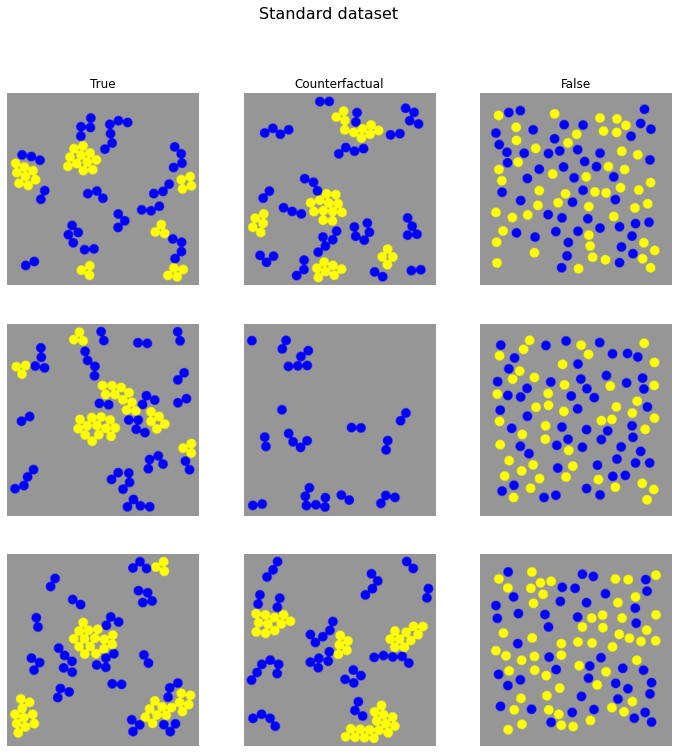

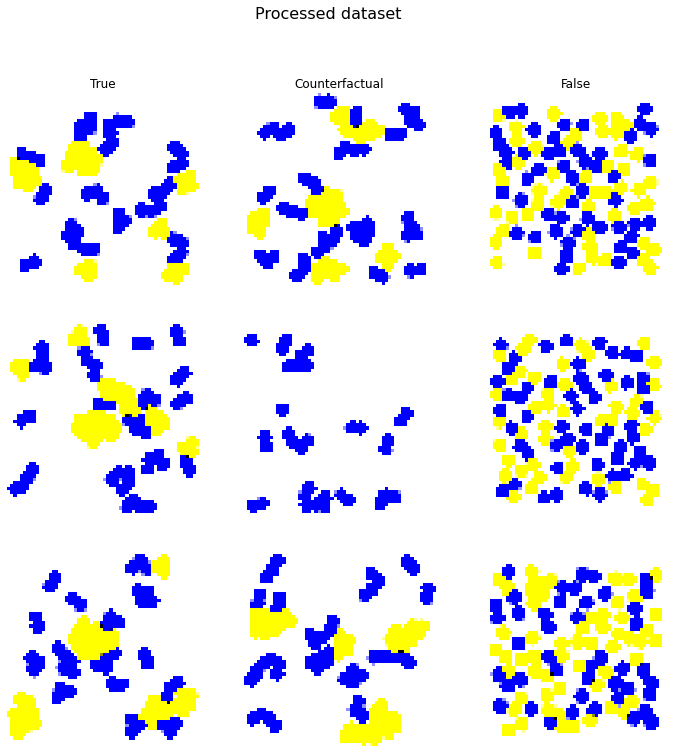

In [ ]:
import torchvision.transforms.functional as TF
def displayImage(image, ax=None, title=None):
    if ax is None:
        fig, ax = plt.subplots()
    image = image.numpy().transpose((1, 2, 0))

    ax.imshow(image)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.tick_params(axis='both', length=0)
    ax.set_xticklabels('')
    ax.set_yticklabels('')
    ax.set_title(title)

    return ax
def displayDataset(dataset, title=None):
    fig, ax = plt.subplots(3, 3, figsize=(12, 12))
    fig.suptitle(title, fontsize=16)
    def display(i, a, title=None):
      image, _ = dataset[i]
      displayImage(image, a, title)
    
    display(2000, ax[0,0], "True")
    display(2001, ax[1,0])
    display(2002, ax[2,0])
    display(1, ax[0,1], "Counterfactual")
    display(3, ax[1,1])
    display(5, ax[2,1])
    display(0, ax[0,2], "False")
    display(2, ax[1,2])
    display(4, ax[2,2])

    plt.show()

def buildDatasetWithTransform(transform, displayAs=None):
    dataset = torchvision.datasets.ImageFolder('./dataset', transform=transform)
    if displayAs is not None:
        displayDataset(dataset, displayAs)
    masterSeed(7)
    train_set, test_set = torch.utils.data.random_split(dataset, [int(len(dataset)*0.8), int(len(dataset)*0.2)])
    return train_set, test_set
def buildDatasets():
  dataset_standard = buildDatasetWithTransform(
      torchvision.transforms.Compose([
          # zmiana rozmiaru, ponieważ batch wielkości 10 zajmował zbyt dużo pamięci 
          # na GPU (oryginały mają 600x600)
          torchvision.transforms.Resize((300, 300)),
          torchvision.transforms.ToTensor()
  ]), "Standard dataset")

  class HighContrastTransform(object):
    def __call__(self, sample):
        return TF.adjust_contrast(sample, 20000)
  dataset_processed = buildDatasetWithTransform(
      torchvision.transforms.Compose([
          torchvision.transforms.Resize((60, 60)),
          HighContrastTransform(),
          torchvision.transforms.ToTensor()
  ]), "Processed dataset")

  return dataset_standard, dataset_processed

(datasets_standard, datasets_processed) = buildDatasets()

## Modelowanie

Część kodu zaczerpnieta z: https://github.com/kuangliu/pytorch-cifar/blob/master/models/resnet.py

In [ ]:
import torch.nn as nn
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
import matplotlib.pyplot as plt

from resnet18 import ResNet18
from train_function import train

def visualizeModel(model, train_plot, test_plot, test_set, title=""):
  fig, ax = plt.subplots(1, 2, figsize=(20, 8))
  fig.suptitle(title, fontsize=16)
  trainingGraph(train_plot, test_plot, ax[0])
  confusionMatrix(model, test_set, ax[1])
  plt.show()
def trainingGraph(train_plot, test_plot, ax):
  ax.plot(np.arange(len(train_plot)), train_plot, color = 'blue')
  ax.plot(np.arange(len(test_plot)), test_plot, color = 'red')
  ax.legend(['Train set', 'Test set'])
  ax.set_xlabel('Epoch')
  ax.set_ylabel('Accuracy value')
  ax.set_title('Training')
def confusionMatrix(model, test_set, ax):
  single_test_loader = torch.utils.data.DataLoader(test_set, shuffle=False, num_workers=2, batch_size=1)
  model.eval()

  y_hat = []
  y_test = []
  for batch in single_test_loader:     
      images = batch[0].to(DEVICE)
      labels = batch[1].to(DEVICE)
      preds = model(images)
      _, predicted = preds.max(1)
      y_hat += predicted.tolist()
      y_test += labels.tolist()

  cm = confusion_matrix(y_test, y_hat)
  disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["false", "true"])
  disp.plot(ax=ax)
  plt.title('Confusion matrix on test set')
  plt.xticks(rotation=30)

[Resnet on raw dataset]
Epoch: 0, train accuracy: 0.6929166666666666, test accuracy: 0.74
Epoch: 1, train accuracy: 0.73, test accuracy: 0.7216666666666667
Epoch: 2, train accuracy: 0.7554166666666666, test accuracy: 0.72
Epoch: 3, train accuracy: 0.7495833333333334, test accuracy: 0.7233333333333334
Epoch: 4, train accuracy: 0.7579166666666667, test accuracy: 0.74
Epoch: 5, train accuracy: 0.7625, test accuracy: 0.7266666666666667
Epoch: 6, train accuracy: 0.78125, test accuracy: 0.735
Epoch: 7, train accuracy: 0.79125, test accuracy: 0.7066666666666667
Epoch: 8, train accuracy: 0.79, test accuracy: 0.71
Epoch: 9, train accuracy: 0.8170833333333334, test accuracy: 0.7216666666666667


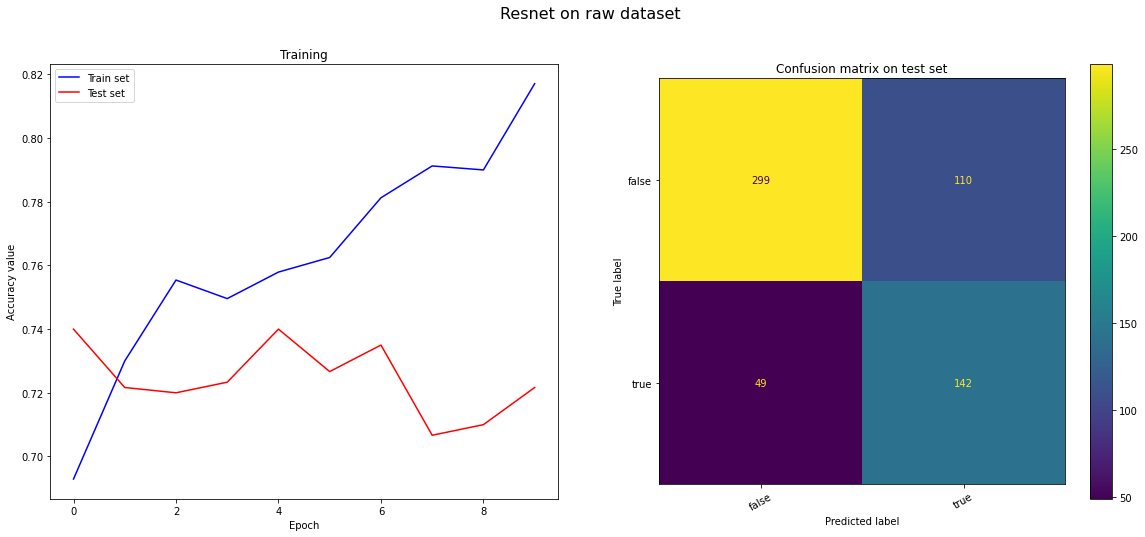

[Resnet on processed dataset]
Epoch: 0, train accuracy: 0.6858333333333333, test accuracy: 0.7016666666666667
Epoch: 1, train accuracy: 0.7195833333333334, test accuracy: 0.73
Epoch: 2, train accuracy: 0.735, test accuracy: 0.715
Epoch: 3, train accuracy: 0.6841666666666667, test accuracy: 0.7316666666666667
Epoch: 4, train accuracy: 0.72375, test accuracy: 0.7316666666666667
Epoch: 5, train accuracy: 0.71125, test accuracy: 0.7116666666666667
Epoch: 6, train accuracy: 0.7433333333333333, test accuracy: 0.7233333333333334
Epoch: 7, train accuracy: 0.7441666666666666, test accuracy: 0.72
Epoch: 8, train accuracy: 0.7325, test accuracy: 0.7083333333333334
Epoch: 9, train accuracy: 0.7458333333333333, test accuracy: 0.7216666666666667


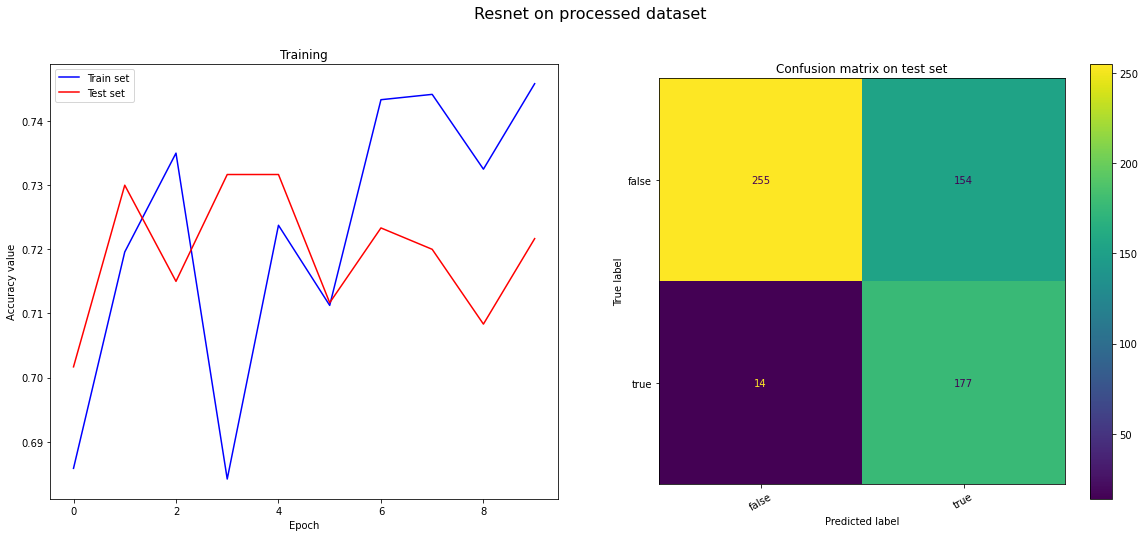

In [ ]:
def generateResnetModel(train_set, test_set, last_layer_size, save_as, visualization_title=""):
  masterSeed(13)
  train_loader = torch.utils.data.DataLoader(train_set, shuffle=True, num_workers=2, batch_size=10)
  test_loader = torch.utils.data.DataLoader(test_set, shuffle=False, num_workers=2, batch_size=10)

  model = ResNet18()
  model.linear = nn.Linear(last_layer_size, 2)
  model = model.to(DEVICE)

  criterion = torch.nn.CrossEntropyLoss()
  optimizer = torch.optim.Adam(model.parameters(), lr = 0.001)
  epochs = 10
  if visualization_title != "":
    print("["+visualization_title+"]")
  train_plot, test_plot = train(model, criterion, optimizer, 0, epochs, train_loader, test_loader, DEVICE, [], [])

  torch.save(model.state_dict(), '/content/drive/MyDrive/projekt-WB/'+save_as+'.model')
  visualizeModel(model, train_plot, test_plot, test_set, visualization_title)
  return model

model_standard_resnet = generateResnetModel(*datasets_standard, 41472, 'standard_resnet', "Resnet on raw dataset")
model_processed_resnet = generateResnetModel(*datasets_processed, 2048, 'processed_resnet', "Resnet on processed dataset")

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


  0%|          | 0.00/44.7M [00:00<?, ?B/s]

[Pretrained resnet on raw dataset]
Epoch: 0, train accuracy: 0.7083333333333334, test accuracy: 0.7033333333333334
Epoch: 1, train accuracy: 0.75, test accuracy: 0.7166666666666667
Epoch: 2, train accuracy: 0.7229166666666667, test accuracy: 0.72
Epoch: 3, train accuracy: 0.735, test accuracy: 0.7216666666666667
Epoch: 4, train accuracy: 0.7254166666666667, test accuracy: 0.6816666666666666
Epoch: 5, train accuracy: 0.7554166666666666, test accuracy: 0.805
Epoch: 6, train accuracy: 0.8304166666666667, test accuracy: 0.8483333333333334
Epoch: 7, train accuracy: 0.83625, test accuracy: 0.8416666666666667
Epoch: 8, train accuracy: 0.8491666666666666, test accuracy: 0.8266666666666667
Epoch: 9, train accuracy: 0.8654166666666666, test accuracy: 0.855
Epoch: 10, train accuracy: 0.88125, test accuracy: 0.8633333333333333
Epoch: 11, train accuracy: 0.8720833333333333, test accuracy: 0.85
Epoch: 12, train accuracy: 0.89875, test accuracy: 0.8416666666666667
Epoch: 13, train accuracy: 0.90125, 

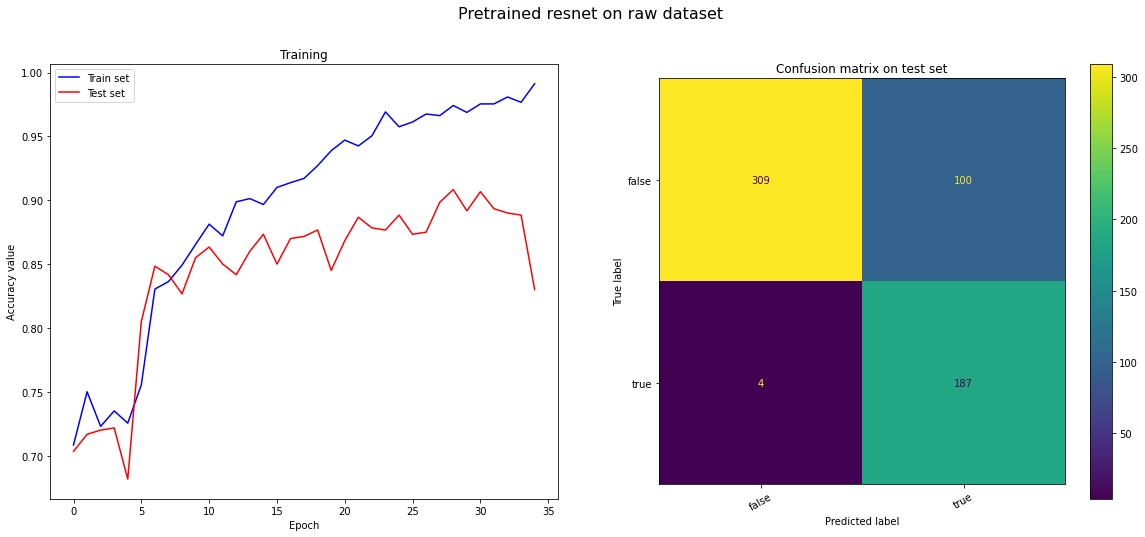

[Pretrained resnet on processed dataset]
Epoch: 0, train accuracy: 0.6891666666666667, test accuracy: 0.6866666666666666
Epoch: 1, train accuracy: 0.7166666666666667, test accuracy: 0.7233333333333334
Epoch: 2, train accuracy: 0.7329166666666667, test accuracy: 0.7183333333333334
Epoch: 3, train accuracy: 0.7454166666666666, test accuracy: 0.7266666666666667
Epoch: 4, train accuracy: 0.7608333333333334, test accuracy: 0.695
Epoch: 5, train accuracy: 0.7725, test accuracy: 0.7283333333333334
Epoch: 6, train accuracy: 0.7783333333333333, test accuracy: 0.7233333333333334
Epoch: 7, train accuracy: 0.7658333333333334, test accuracy: 0.7016666666666667
Epoch: 8, train accuracy: 0.7679166666666667, test accuracy: 0.725
Epoch: 9, train accuracy: 0.78625, test accuracy: 0.725
Epoch: 10, train accuracy: 0.8029166666666666, test accuracy: 0.7066666666666667
Epoch: 11, train accuracy: 0.8529166666666667, test accuracy: 0.705
Epoch: 12, train accuracy: 0.8741666666666666, test accuracy: 0.715
Epoc

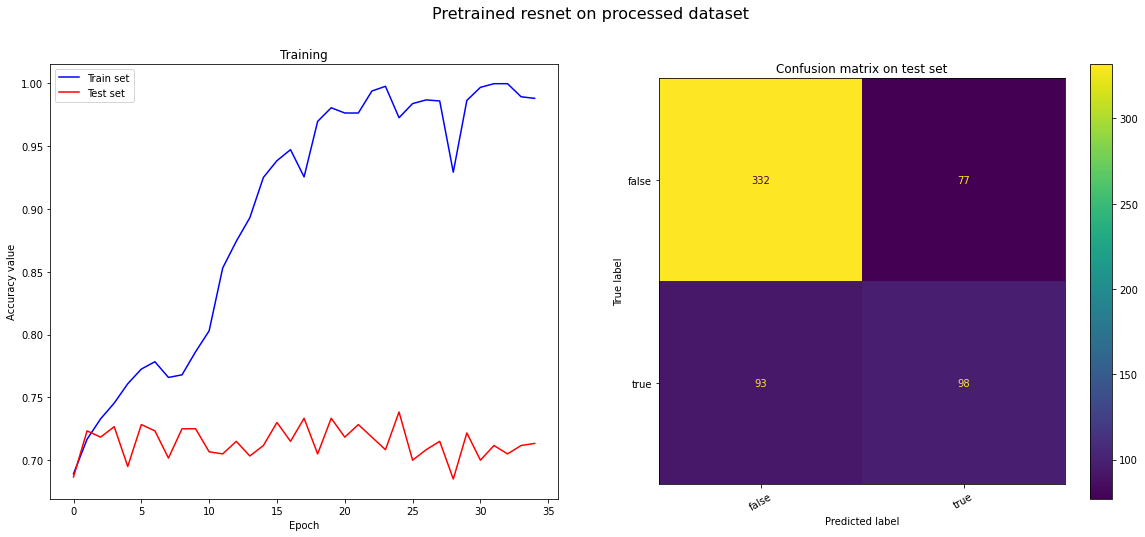

In [ ]:
def generatePretrainedResnetModel(train_set, test_set, save_as, visualization_title=""):
  masterSeed(13)
  train_loader = torch.utils.data.DataLoader(train_set, shuffle=True, num_workers=2, batch_size=10)
  test_loader = torch.utils.data.DataLoader(test_set, shuffle=False, num_workers=2, batch_size=10)

  model = torchvision.models.resnet18(pretrained = True)
  model.fc = nn.Linear(512, 2)
  model = model.to(DEVICE)

  criterion = torch.nn.CrossEntropyLoss()
  optimizer = torch.optim.Adam(model.parameters(), lr = 0.001)
  epochs = 30
  if visualization_title != "":
    print("["+visualization_title+"]")
  train_plot, test_plot = train(model, criterion, optimizer, 0, epochs, train_loader, test_loader, DEVICE, [], [])

  torch.save(model.state_dict(), '/content/drive/MyDrive/projekt-WB/'+save_as+'.model')
  visualizeModel(model, train_plot, test_plot, test_set, visualization_title)
  return model

model_standard_pretrained_resnet = generatePretrainedResnetModel(*datasets_standard, 'standard_pretrained_resnet', "Pretrained resnet on raw dataset")
model_processed_pretrained_resnet = generatePretrainedResnetModel(*datasets_processed, 'processed_pretrained_resnet', "Pretrained resnet on processed dataset")

## Wyjaśnienia

In [ ]:
import os
import torch
import torchvision
import random
import numpy as np
import matplotlib.pyplot as plt

if torch.cuda.is_available():  
    DEVICE = "cuda:0" 
else:  
    DEVICE = "cpu"

def masterSeed(seed):
    torch.manual_seed(seed)
    random.seed(seed)
    np.random.seed(seed)

from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
! cp /content/drive/MyDrive/projekt-WB/explain.py ./explain.py
! cp /content/drive/MyDrive/projekt-WB/resnet18.py ./resnet18.py
! cp /content/drive/MyDrive/projekt-WB/train_function.py ./train_function.py
! git clone https://github.com/human-centered-ai-lab/dat-kandinsky-patterns
! mv ./dat-kandinsky-patterns/challenge-nr-3/ ./dataset

folder = './dataset/counterfactual/'
for count, filename in enumerate(os.listdir(folder)):
    dst = filename + "_counterfactual.png"
    src =f"{folder}/{filename}"
    dst =f"{folder}/{dst}"
    os.rename(src, dst)

! cp -r ./dataset/counterfactual/. ./dataset/false/
! rm -R ./dat-kandinsky-patterns
! mkdir ./counterf
! mv ./dataset/counterfactual/ ./counterf/counterfactual/

Cloning into 'dat-kandinsky-patterns'...
remote: Enumerating objects: 22535, done.
remote: Total 22535 (delta 0), reused 0 (delta 0), pack-reused 22535
Receiving objects: 100% (22535/22535), 396.91 MiB | 28.07 MiB/s, done.
Resolving deltas: 100% (357/357), done.
Checking out files: 100% (11253/11253), done.


In [ ]:
import torchvision.transforms.functional as TF
def displayImage(image, ax=None, title=None):
    if ax is None:
        fig, ax = plt.subplots()
    image = image.numpy().transpose((1, 2, 0))

    ax.imshow(image)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.tick_params(axis='both', length=0)
    ax.set_xticklabels('')
    ax.set_yticklabels('')
    ax.set_title(title)

    return ax
def displayDataset(dataset, title=None):
    fig, ax = plt.subplots(3, 3, figsize=(12, 12))
    fig.suptitle(title, fontsize=16)
    def display(i, a, title=None):
      image, _ = dataset[i]
      displayImage(image, a, title)
    
    display(2000, ax[0,0], "True")
    display(2001, ax[1,0])
    display(2002, ax[2,0])
    display(1, ax[0,1], "Counterfactual")
    display(3, ax[1,1])
    display(5, ax[2,1])
    display(0, ax[0,2], "False")
    display(2, ax[1,2])
    display(4, ax[2,2])

    plt.show()

def buildDatasetWithTransform(transform, displayAs=None):
    dataset = torchvision.datasets.ImageFolder('./dataset', transform=transform)
    if displayAs is not None:
        displayDataset(dataset, displayAs)
    masterSeed(7)
    train_set, test_set = torch.utils.data.random_split(dataset, [int(len(dataset)*0.8), int(len(dataset)*0.2)])
    return train_set, test_set
def buildDatasets():
  dataset_standard = buildDatasetWithTransform(
      torchvision.transforms.Compose([
          # zmiana rozmiaru, ponieważ batch wielkości 10 zajmował zbyt dużo pamięci 
          # na GPU (oryginały mają 600x600)
          torchvision.transforms.Resize((300, 300)),
          torchvision.transforms.ToTensor()
  ]))

  class HighContrastTransform(object):
    def __call__(self, sample):
        return TF.adjust_contrast(sample, 20000)
  dataset_processed = buildDatasetWithTransform(
      torchvision.transforms.Compose([
          torchvision.transforms.Resize((60, 60)),
          HighContrastTransform(),
          torchvision.transforms.ToTensor()
  ]))

  return dataset_standard, dataset_processed

(datasets_standard, datasets_processed) = buildDatasets()

In [ ]:
standard_train_set, standard_test_set = datasets_standard
processed_train_set, processed_test_set = datasets_processed

In [ ]:
import torch.nn as nn
from resnet18 import ResNet18

model_standard = torchvision.models.resnet18(pretrained = True)
model_standard.fc = nn.Linear(512, 2)
model_standard.load_state_dict(torch.load('/content/drive/MyDrive/projekt-WB/standard_pretrained_resnet.model'))
model_standard.eval()

model_processed = torchvision.models.resnet18(pretrained = True)
model_processed.fc = nn.Linear(512, 2)
model_processed.load_state_dict(torch.load('/content/drive/MyDrive/projekt-WB/processed_pretrained_resnet.model'))
model_processed.eval()

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


  0%|          | 0.00/44.7M [00:00<?, ?B/s]

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [ ]:
! pip install captum

     |████████████████████████████████| 1.4 MB 5.4 MB/s 


In [ ]:
standard_loader = torch.utils.data.DataLoader(standard_test_set, shuffle=False, num_workers=2, batch_size=1)
processed_loader = torch.utils.data.DataLoader(processed_test_set, shuffle=False, num_workers=2, batch_size=1)

In [ ]:
import matplotlib.pyplot as plt

def get_label(lab):
  return 'True' if lab else 'False'

def show_img(idx):
  img_s, lab = standard_test_set[idx]
  img_p = processed_test_set[idx][0]

  fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,6))
  fig.suptitle('Image number ' + str(idx) + '\nMatches GT? ' + get_label(lab))

  ax1.axis('off')
  ax1.imshow(img_s.permute(1, 2, 0))
  ax1.set_title('Predicted ' + get_label(model_standard(img_s.unsqueeze(0)).max(1)[1].item()))

  ax2.axis('off')
  ax2.imshow(img_p.permute(1, 2, 0))
  ax2.set_title('Predicted ' + get_label(model_processed(img_p.unsqueeze(0)).max(1)[1].item()))

  plt.show()

In [ ]:
from captum.attr import Lime, IntegratedGradients, KernelShap
from skimage import segmentation
from explain import lime_explain, SHAP_explain

In [ ]:
from itertools import product
from queue import Queue

def make_mask(img, bg=(0.5882353187, 0.5882353187, 0.5882353187), tolerance=(0.7, 0.7, 0.7), bg_tolerance=(0.5, 0.5, 0.5), max_dist=16):
  mask = -torch.ones(img.shape[1:])
  mask[(torch.abs(img[0]-bg[0])<bg_tolerance[0]) & (torch.abs(img[1]-bg[1])<bg_tolerance[1]) & (torch.abs(img[2]-bg[2])<bg_tolerance[1])] = 0

  def get_neighbours(x, y):
    res = []
    if x-1 > 0:
      res.append((x-1, y))
    if y-1 > 0 :
      res.append((x, y-1))
    if x+1 < img.shape[1]:
      res.append((x+1, y))
    if y+1 < img.shape[2]:
      res.append((x, y+1))
    return res

  def get_color(x, y):
    return img[0][x][y], img[1][x][y], img[2][x][y]

  def is_close(col1, col2):
    return all(np.absolute(np.array(col1) - np.array(col2)) < np.array(tolerance))

  def fill(x, y, color):
    start_color = get_color(x, y)
    start_x, start_y = x, y
    q = Queue()
    q.put((x, y))
    while not q.empty():
      x, y = q.get()
      if mask[x][y] < 0:
        mask[x][y] = color
      neighbours = get_neighbours(x, y)
      for nx, ny in neighbours:
        if is_close(get_color(nx, ny), start_color) and mask[nx][ny] == -1 and (start_x-x)**2 + (start_y-y)**2 < max_dist:
          q.put((nx, ny))
          mask[nx][ny] = -2

  i = 1
  for x, y in product(range(img.shape[1]), range(img.shape[2])):
    if mask[x][y] < 0:
      fill(x, y, i)
      i+=1

  return torch.tensor(mask, dtype=torch.long), i

In [ ]:
mask, i = make_mask(img_s, max_dist=200)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:47: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


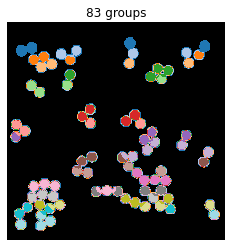

In [ ]:
plt.imshow(mask, cmap=my_cmap, vmin=0.001)
plt.title(f'{i} groups')
plt.axis('off')
plt.show()

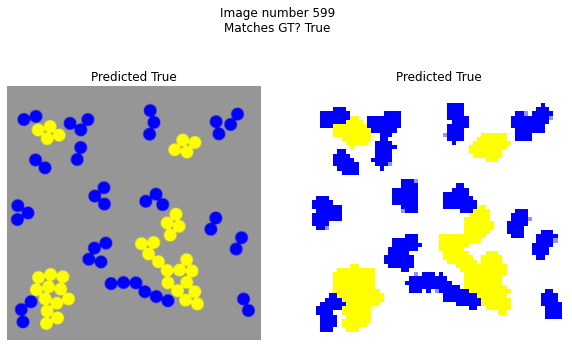

In [ ]:
show_img(idx)

In [ ]:
from captum.attr import visualization
from matplotlib import cm

my_cmap = cm.get_cmap('tab20')
my_cmap.set_under('black')

def comp_explanations(model, img, label, pred, save_name=None):
  fig, axs = plt.subplots(2, 3, figsize=(18, 10))
  fig.suptitle(f'|Class:        {label}|Predicted:    {pred}|', fontsize=18)
  
  # Original Image
  axs[0][0].axis('off')
  im = axs[0][0].imshow(img.permute(1, 2, 0))
  axs[0][0].set_title('Original Image')
  print("Image done")

  # Mask
  if img.shape[1:] == (300, 300):
    mask, i = make_mask(img, max_dist=200)
  else:
    mask, i = make_mask(img, bg=(1., 1., 1.))
  axs[0][1].axis('off')
  im = axs[0][1].imshow(mask, cmap=my_cmap, vmin=0.001)
  axs[0][1].set_title(f'Mask ({i} groups)')
  print("Mask done")

  axs[0][2].axis('off')

  # IG
  explainer = IntegratedGradients(model)
  attr = explainer.attribute(img.unsqueeze(0), target=label)
  axs[1][0].axis('off')
  lim = max(attr[0].mean(axis=0).min().abs(), attr[0].mean(axis=0).max().abs())
  im = axs[1][0].imshow(attr[0].mean(axis=0), vmin=-lim, vmax=lim, cmap="RdBu")
  axs[1][0].set_title('IG')
  fig.colorbar(im, ax=axs[1][0])
  print("IG done")

  # LIME
  explainer = Lime(model)
  attr = explainer.attribute(
      img.unsqueeze(0), 
      target=label, 
      n_samples=200, 
      feature_mask=torch.as_tensor(mask),
      show_progress=False
  )
  axs[1][1].axis('off')
  im = axs[1][1].imshow(attr[0].mean(axis=0), vmin=-1, vmax=1, cmap="RdBu")
  axs[1][1].set_title('LIME')
  fig.colorbar(im, ax=axs[1][1])
  print("LIME done")
  
  # SHAP
  explainer = KernelShap(model)
  attr = explainer.attribute(
      img.unsqueeze(0), 
      target=label, 
      n_samples=200, 
      feature_mask=torch.as_tensor(mask),
      show_progress=False
  )
  axs[1][2].axis('off')
  im = axs[1][2].imshow(attr[0].mean(axis=0), vmin=-1, vmax=1, cmap="RdBu")
  axs[1][2].set_title('SHAP')
  fig.colorbar(im, ax=axs[1][2])
  print("SHAP done")

  print("All done")
  plt.show()
  if save_name is not None: plt.savefig(f'/content/drive/MyDrive/projekt-WB/{save_name}.png')

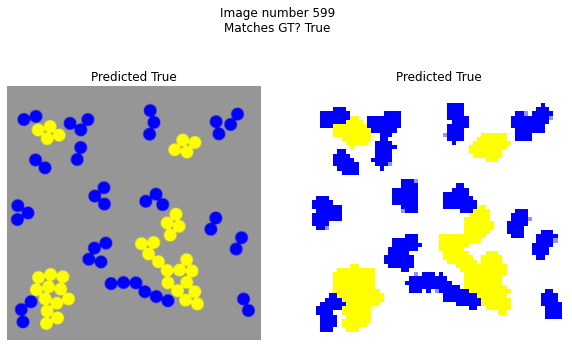

In [ ]:
  idx = 599

  img_s, lab = standard_test_set[idx]
  img_p = processed_test_set[idx][0]

  show_img(idx)

Image done


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:47: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Mask done
IG done
LIME done
SHAP done
All done


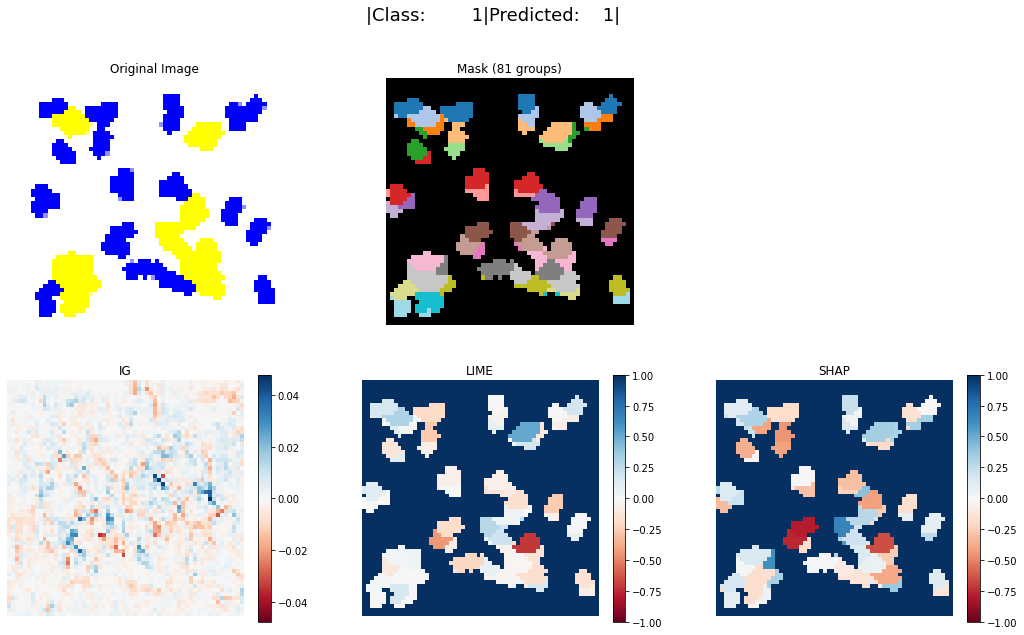

In [ ]:
comp_explanations(model_processed, img_p, lab, model_processed(img_p.unsqueeze(0)).max(1)[1].item())

Image done


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:47: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Mask done
IG done
LIME done
SHAP done
All done


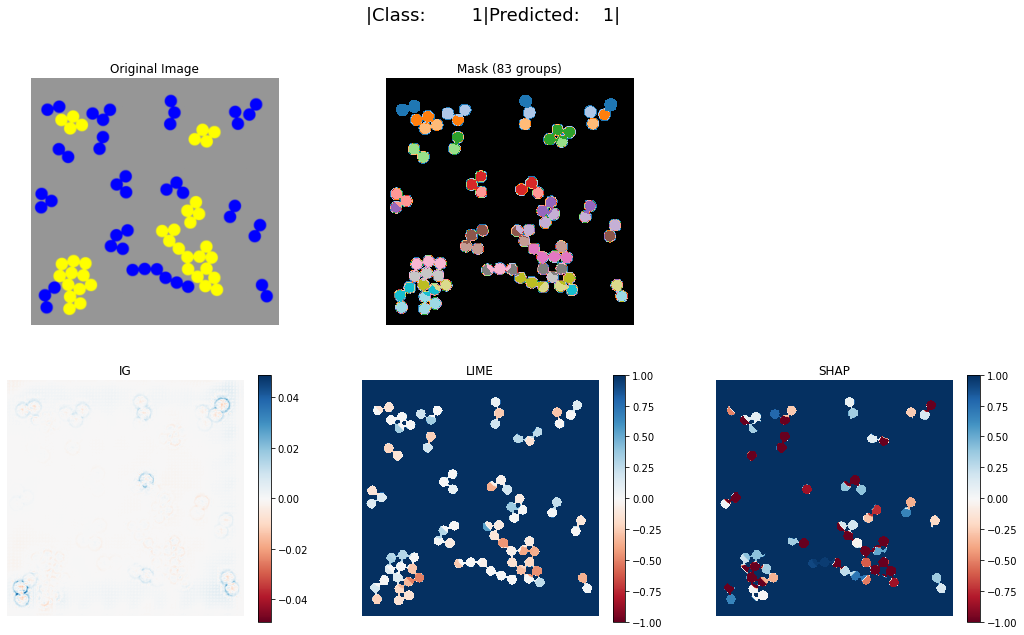

In [ ]:
comp_explanations(model_standard, img_s, lab, model_standard(img_s.unsqueeze(0)).max(1)[1].item())

## Próba pierwszych wyjaśnień

In [ ]:
from google.colab import drive

drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
! cp /content/drive/MyDrive/projekt-WB/explain.py ./explain.py
! cp /content/drive/MyDrive/projekt-WB/resnet18.py ./resnet18.py
! cp /content/drive/MyDrive/projekt-WB/train_function.py ./train_function.py

In [ ]:
! rm -R ./dataset
! rm -R ./dat-kandinsky-patterns
! git clone https://github.com/human-centered-ai-lab/dat-kandinsky-patterns
! mv ./dat-kandinsky-patterns/challenge-nr-3/ ./
! mv ./challenge-nr-3 ./dataset

rm: cannot remove './dat-kandinsky-patterns': No such file or directory
Cloning into 'dat-kandinsky-patterns'...
remote: Enumerating objects: 22535, done.
remote: Total 22535 (delta 0), reused 0 (delta 0), pack-reused 22535
Receiving objects: 100% (22535/22535), 396.91 MiB | 24.71 MiB/s, done.
Resolving deltas: 100% (357/357), done.
Checking out files: 100% (11253/11253), done.


In [ ]:
import os

folder = './dataset/counterfactual/'

for count, filename in enumerate(os.listdir(folder)):
    dst = filename + "_counterfactual.png"
    src =f"{folder}/{filename}"
    dst =f"{folder}/{dst}"
    os.rename(src, dst)

In [ ]:
! cp -r ./dataset/counterfactual/. ./dataset/false/
! rm -R ./dat-kandinsky-patterns
! rm -R ./dataset/counterfactual/

In [ ]:
import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
from resnet18 import ResNet18


transforms = torchvision.transforms.Compose([
    # zmiana rozmiaru, ponieważ batch wielkości 10 zajmował zbyt dużo pamięci 
    # na GPU (oryginały mają 600x600)
    torchvision.transforms.Resize((300, 300)),
    torchvision.transforms.ToTensor()
])

dataset = torchvision.datasets.ImageFolder('./dataset', transform=transforms)

#zaladowanie test
test_set = torch.load('/content/drive/MyDrive/projekt-WB/test_set_4')

model = ResNet18()
model.linear = nn.Linear(41472, 2)
model.load_state_dict(torch.load('/content/drive/MyDrive/projekt-WB/model_4.model'))
model.eval()

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (shortcut): Sequential()
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=

In [ ]:
! pip install captum

In [ ]:
single_test_loader = torch.utils.data.DataLoader(test_set, shuffle=False, num_workers=2, batch_size=1)

In [ ]:
idx = 0

i = 0
img = None
for batch in single_test_loader:  
      if i == idx:
          img = batch[0][0]
          label = batch[1]
          break
      i = i + 1

_, predicted = model(img.unsqueeze(0)).max(1)
predicted = predicted.item()

In [ ]:
print(f'Classification explanation, predicted class: {dataset.classes[predicted]}, true class: {dataset.classes[label.item()]}')

Classification explanation, predicted class: true, true class: true


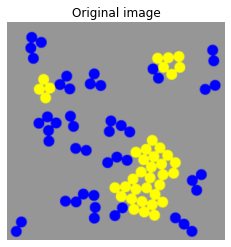

In [ ]:
import matplotlib.pyplot as plt

plt.axis("off")
plt.title('Original image')
plt.imshow(img.permute(1, 2, 0))
plt.show()

In [ ]:
from captum.attr import Lime, IntegratedGradients, KernelShap
from skimage import segmentation

In [ ]:
from explain import lime_explain

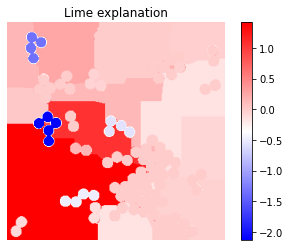

In [ ]:
lime_explain(model, img, label.item())
plt.title("Lime explanation")
plt.show()

In [ ]:
from explain import SHAP_explain

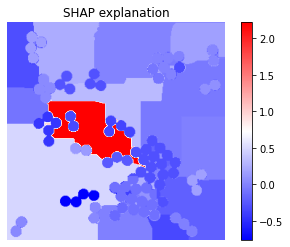

In [ ]:
import matplotlib.pyplot as plt

SHAP_explain(model, img, label)
plt.title("SHAP explanation")
plt.show()

# Przeczytane artykuły:

## You Only Look Once: Unified, Real-Time Object Detection

https://arxiv.org/pdf/1506.02640.pdf

Patryk Tomaszewski

Autorzy YOLO (You Only Look Once) starają się rozwiązać problem detekcji i klasyfikacji wielu obiektów na zdjęciu w czasie rzeczywistym. Zaproponowana przez nich architektura jest w stanie przetworzyć 45 zdjęć na sekund dzięki zrezygnowaniu ze standardowego podejścia bazującego na pipeline składającego się z poszczególnych modułów które trzeba oddzielnie uczyć i uruchamiać. Zamiast tego, dzielą zdjęcie wejściowe na SxS pól, z czego każde pole odpowiada za propozycję B bounding-boxów (reprezentowanych jako wysokość, szerokość, pozycja x, pozycja y i pewność predykcji) i policzenie prawdopodobieństwa dla każdej z możliwych klas że obiekt nachodzi na to pole. Taka architektura sprawia że końcowo zwracaną wartością jest pojedynczy tensor o wymiarach SxSx(B*5+C), co nie tylko znacząco przyśpiesza proces predykcji, ale pozwala także uczyć cały model jednocześnie. W swojej klasie prędkości architektura YOLO osiąga jedne z najlepszych wyników (które są jednak niższe niż te uzyskane przez modele o znacząco dłuższym czasie przetwarzania), sieć także rzadko predykuje elementy których tak naprawdę nie ma lub są jedynie tłem, jednak w porównaniu do innych modeli dużo większy procent błędów spowodowany jest niedokładnym wykryciem bounding-boxa. Autorzy także utworzyli mniej dokładny model Fast YOLO, o którym twierdzą że jest najszybszym modelem w znanej literaturze, osiągając prędkość 150 zdjęć na sekundę.

## Neuro-symbolic forward reasoning

https://arxiv.org/pdf/2110.09383.pdf?

Adrian Stańdo

Autorzy artykułu podjęli się wyzwania stworzenia nowej architektury sieci (NSFR) oraz przetestowania jej na zbiorach 2D Kandinsky Patterns oraz 3D CLEVR-Hans. Artykuł zawiera szczegółowy matematyczny opis metody. Polega ona na przedstawieniu obiektów znajdujących się na zdjęciu i ich cech w postaci tabelarycznej, następnie przedstawieniu ich w postaci prawdopodobieństw występowania wcześniej zdefiniowanych cech, a następnie predykcji. Autorzy porównali wyniki ich sieci z innymi rozwiązaniami na różnych zbiorach Kandinsky: ResNet50 oraz YOLO+MLP. Okazało się, że pierwsza z nich się przeuczyła, druga uzyskała dość wysokie wyniki dla większości zbiorów, a NSFR uzyskał w większości przypadków 100% accuracy, zarówno na zbiorze treningowym, jak i testowym. Minusem przedstawionej metody jest to, że cechy obiektów i ich położeń są parametrami metody - muszą być wcześniej zdefiniowane, a zatem nie jest to metoda w pełni automatyczna jak ResNet.


## Measuring the Quality of Explanations: The System Causability Scale (SCS)

https://link.springer.com/article/10.1007/s13218-020-00636-z

Krzysztof Wodnicki

W artykule została zaproponowana metoda SCS, która ma służyć do szybkiej oceny przydatności wyjaśnień. Autorzy metody silnie inspirowali się skalą SUS (System Usability Scale), służącą do oceny przydatności interfejsu, ale powszechnie używanej też w kontekście innych produktów. Metoda polega na przeprowadzeniu ankiety w której użytkownicy mają wybrać na ile zgadzają się z podanymi stwierdzeniami, a ich odpowiedzi są zamieniane na wynik punktowy. Wśród wad metody autorzy wymieniają trudności z interpretacją wyniku - mimo tego, że jest to liczba od 0 do 1 nie można go interpretowac jako procent. Skala najlepiej sprawdza się przy porównywaniu różnych metod, na przykład poprzez wyliczenie centyli na podstawie wyników. Trudności sprawia także dobranie wag do konkretnych pytań i odpowiedzi tak, aby wynik punktowy sensownie odzwierciedlał przydatność wyjaśnień.